HOG 特征维度: (8100,)


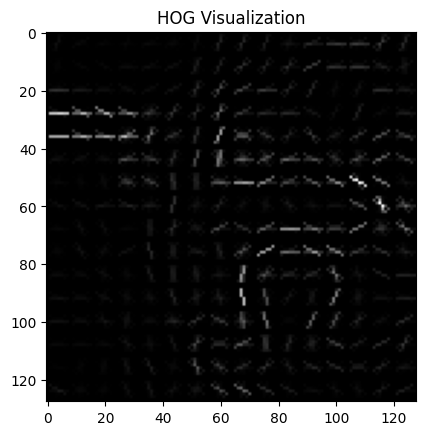

In [ ]:
# from skimage.feature import hog
# from skimage import io, color
# import cv2

# # 读取图像
# img = io.imread("/home/iwintern2/Personal/COMP3314/data/train_ims/0a0e9c7.jpg")
# img_gray = color.rgb2gray(img)  # 转换为灰度图像
# img_resized = cv2.resize(img_gray, (128, 128), interpolation=cv2.INTER_CUBIC)

# # 计算 HOG 特征
# hog_features, hog_image = hog(
#     img_resized,
#     orientations=9,         # 梯度方向的分箱数
#     pixels_per_cell=(8, 8), # 每个单元格的像素数
#     cells_per_block=(2, 2), # 每个块的单元格数
#     block_norm='L2-Hys',    # 块归一化方法
#     visualize=True,         # 是否返回 HOG 可视化图像
#     feature_vector=True     # 是否返回特征向量
# )

# print("HOG 特征维度:", hog_features.shape)

# # 显示 HOG 可视化图像
# import matplotlib.pyplot as plt
# plt.imshow(hog_image, cmap="gray")
# plt.title("HOG Visualization")
# plt.show()

In [6]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from skimage.feature import hog
from skimage import io, color

import cv2  


import torchvision.transforms as transforms

import matplotlib.pyplot as plt

# import cudf
from cuml.decomposition import PCA  # 替换 sklearn 的 PCA
from cuml.ensemble import RandomForestClassifier as cuRF
from cuml.metrics import accuracy_score as cu_accuracy_score
from cuml.svm import SVC
from cuml.metrics import accuracy_score
import time

from tqdm import tqdm 

csv_path = "../../data/train.csv"
img_dir = "../../data/train_ims"
output_dir = "../../data/train_hog_ims"
data = pd.read_csv(csv_path)

transform = transforms.Compose([
    transforms.RandomResizedCrop(224),  # 随机裁剪并调整大小
    transforms.RandomHorizontalFlip(),  # 随机水平翻转
    transforms.RandomRotation(15),     # 随机旋转
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)  # 颜色抖动
    # transforms.ToTensor(),             # 转换为张量
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 标准化
])

X = []
y = []

for _, row in tqdm(data.iterrows(), total=len(data), desc="Processing Images"):
    img_path = os.path.join(img_dir, row.iloc[0])
    label = int(row.iloc[1])
    img_name = os.path.splitext(row.iloc[0])[0]
    img = Image.open(img_path).convert("RGB")
    
    img_gray = color.rgb2gray(img)  # 转换为灰度图像
    img_resized = cv2.resize(img_gray, (128, 128), interpolation=cv2.INTER_CUBIC)

    hog_features, hog_image = hog(
        img_resized,
        orientations=9,         # 梯度方向的分箱数
        pixels_per_cell=(8, 8), # 每个单元格的像素数
        cells_per_block=(2, 2), # 每个块的单元格数
        block_norm='L2-Hys',    # 块归一化方法
        visualize=True,         # 是否返回 HOG 可视化图像
        feature_vector=True     # 是否返回特征向量
    )
    
    hog_image_path = os.path.join(output_dir, f"{img_name}.jpg")
    hog_image_normalized = (hog_image - hog_image.min()) / (hog_image.max() - hog_image.min()) * 255  # 归一化到 0-255
    hog_image_pil = Image.fromarray(hog_image_normalized.astype(np.uint8))  # 转换为 PIL 图像
    hog_image_pil.save(hog_image_path)
    
    img_flattened = hog_image.flatten()

    X.append(img_flattened)
    y.append(label)

X = np.array(X)
y = np.array(y)

Processing Images: 100%|██████████| 50000/50000 [18:02<00:00, 46.19it/s]
